# Seurat harmony, cluster and find Marker

In [1]:
library(tidyverse)
library(harmony)
library(Seurat)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: Rcpp

Loading required package: SeuratObject

Loading required package: sp

‘SeuratObject’ was built under R 4.3.2 but the current version is
4.3.3; it is recomended that you reinstall ‘SeuratObject’ as the ABI
for R may have changed

‘SeuratObject’ was built with package ‘Matrix’ 1.6.3 but the current
version is 1.6.5; it is recomended that you reinstall ‘SeuratObject’ as
the ABI for ‘Matrix’ may have changed


Attaching package: ‘SeuratObject’


In [2]:
packageVersion("harmony")

[1] ‘1.2.0’

In [3]:
adata_count = read.csv('GSE167232_bal_integrated.csv.gz',row.names = 1)
adata_count %>% dim

[1] 20631 10357

In [4]:
df_ann = read.csv("GSE167232_bal_integrated_meta.csv")
df_ann %>% colnames
df_ann %>% head(2)
# df_ann %>% group_by(orig.ident) %>% count
# df_ann %>% group_by(MULTI_ID) %>% count
# df_ann %>% group_by(Treatment) %>% count
# df_ann %>% group_by(Protein) %>% count
# df_ann %>% group_by(Batch) %>% count

# ,cell_type
df_ann %>% group_by(seurat_clusters) %>% count
df_ann %>% dim

[1] "orig.ident"           "nCount_RNA"           "nFeature_RNA"        
 [4] "nCount_HTO"           "nFeature_HTO"         "percent.mt"          
 [7] "MULTI_ID"             "MULTI_classification" "nCount_SCT"          
[10] "nFeature_SCT"         "SCT_snn_res.0.4"      "seurat_clusters"     
[13] "Batch"                "RNA_snn_res.0.6"      "RNA_snn_res.0.4"     
[16] "RNA_snn_res.0.3"      "cell_id"

,orig.ident,nCount_RNA,nFeature_RNA,nCount_HTO,nFeature_HTO,percent.mt,MULTI_ID,MULTI_classification,nCount_SCT,nFeature_SCT,SCT_snn_res.0.4,seurat_clusters,Batch,RNA_snn_res.0.6,RNA_snn_res.0.4,RNA_snn_res.0.3,cell_id
,<chr>,<int>,<int>,<int>,<int>,<dbl>,<chr>,<chr>,<int>,<int>,<int>,<int>,<chr>,<int>,<int>,<int>,<chr>
1,unin_hto,2561,1432,918,3,23.70168,Unin-24-TGATGGCCTATTGGG,Unin-24-TGATGGCCTATTGGG,2743,1430,0,7,Subject 1,9,9,7,AAACCCAAGTGCACCC_1
2,unin_hto,6745,2497,869,3,5.67828,Unin-24-TGATGGCCTATTGGG,Unin-24-TGATGGCCTATTGGG,3785,2188,1,0,Subject 1,0,0,0,AAACCCAGTGAGCTCC_1


seurat_clusters,n
<int>,<int>
0,5154
1,3157
2,1410
3,281
4,162
5,108
6,49
7,36


[1] 10357    17

In [5]:
adata <- CreateSeuratObject(counts = adata_count)
adata@meta.data <- adata@meta.data %>% mutate(
  cell_id = rownames(adata@meta.data), .before = 1
)

adata
# adata@meta.data$cell_id %>% duplicated() %>% any()
# adata@meta.data$cell_id %>% length
# df_ann$cell_id %>% duplicated() %>% any()
# df_ann$cell_id %>% length
# intersect(adata@meta.data$cell_id,df_ann$cell_id ) %>% length

Warning message:
“Data is of class data.frame. Coercing to dgCMatrix.”


An object of class Seurat 
20631 features across 10357 samples within 1 assay 
Active assay: RNA (20631 features, 0 variable features)
 1 layer present: counts

In [6]:
adata@meta.data  <- adata@meta.data %>% left_join(select(df_ann, str_split('cell_id,Batch,seurat_clusters', ",")[[1]]), by = c(
  "cell_id" = "cell_id"
)) %>% rename(
seurat_clusters_article =seurat_clusters)
rownames(adata@meta.data) = adata@meta.data$cell_id

adata@meta.data %>% group_by(seurat_clusters_article) %>% count()
adata@meta.data %>% head(2)
adata@meta.data %>% dim

seurat_clusters_article,n
<int>,<int>
0,5154
1,3157
2,1410
3,281
4,162
5,108
6,49
7,36


,cell_id,orig.ident,nCount_RNA,nFeature_RNA,Batch,seurat_clusters_article
,<chr>,<fct>,<dbl>,<int>,<chr>,<int>
AAACCCAAGTGCACCC_1,AAACCCAAGTGCACCC_1,SeuratProject,2561,1432,Subject 1,7
AAACCCAGTGAGCTCC_1,AAACCCAGTGAGCTCC_1,SeuratProject,6745,2497,Subject 1,0


[1] 10357     6

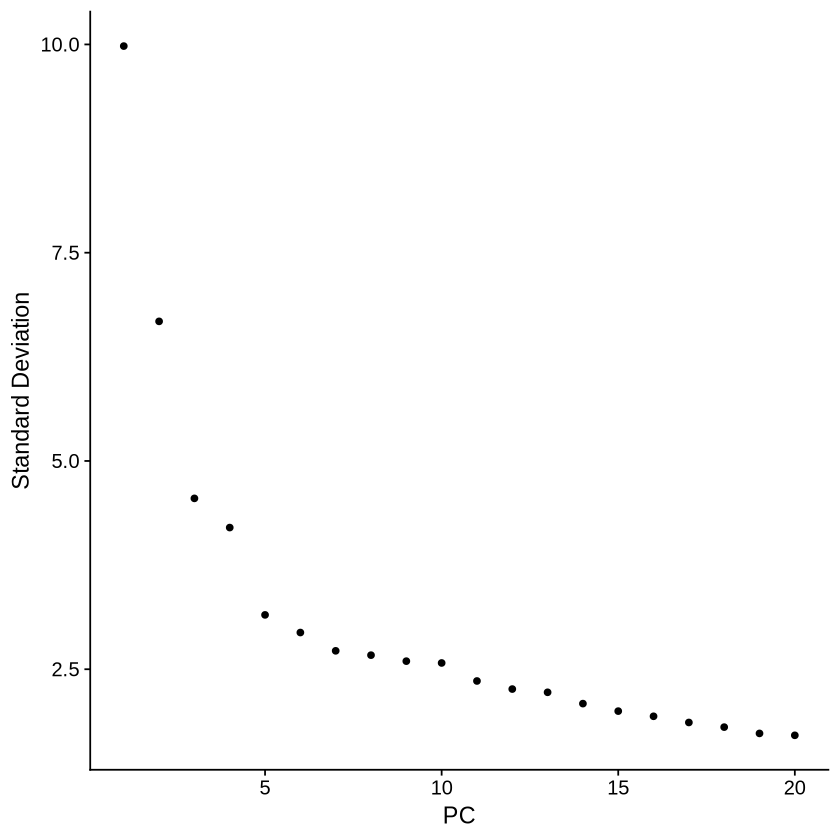

In [7]:
verbose <- F

adata <- Seurat::NormalizeData(adata,verbose = verbose)
adata <- FindVariableFeatures(adata, selection.method = "vst", nfeatures = 3000,verbose = verbose)
adata <- ScaleData(adata,verbose = verbose)
adata <- RunPCA(adata,verbose = verbose)
ElbowPlot(adata)

In [8]:
adata@meta.data = adata@meta.data %>% mutate(
    key_harmony = parse_factor(Batch)
)
adata@meta.data %>% head(2) 
adata@meta.data %>% group_by(key_harmony) %>% count

,cell_id,orig.ident,nCount_RNA,nFeature_RNA,Batch,seurat_clusters_article,key_harmony
,<chr>,<fct>,<dbl>,<int>,<chr>,<int>,<fct>
AAACCCAAGTGCACCC_1,AAACCCAAGTGCACCC_1,SeuratProject,2561,1432,Subject 1,7,Subject 1
AAACCCAGTGAGCTCC_1,AAACCCAGTGAGCTCC_1,SeuratProject,6745,2497,Subject 1,0,Subject 1


key_harmony,n
<fct>,<int>
Subject 1,2394
Subject 2,2167
Subject 3,5796


Transposing data matrix

Initializing state using k-means centroids initialization

Harmony 1/10

Harmony 2/10

Harmony converged after 2 iterations



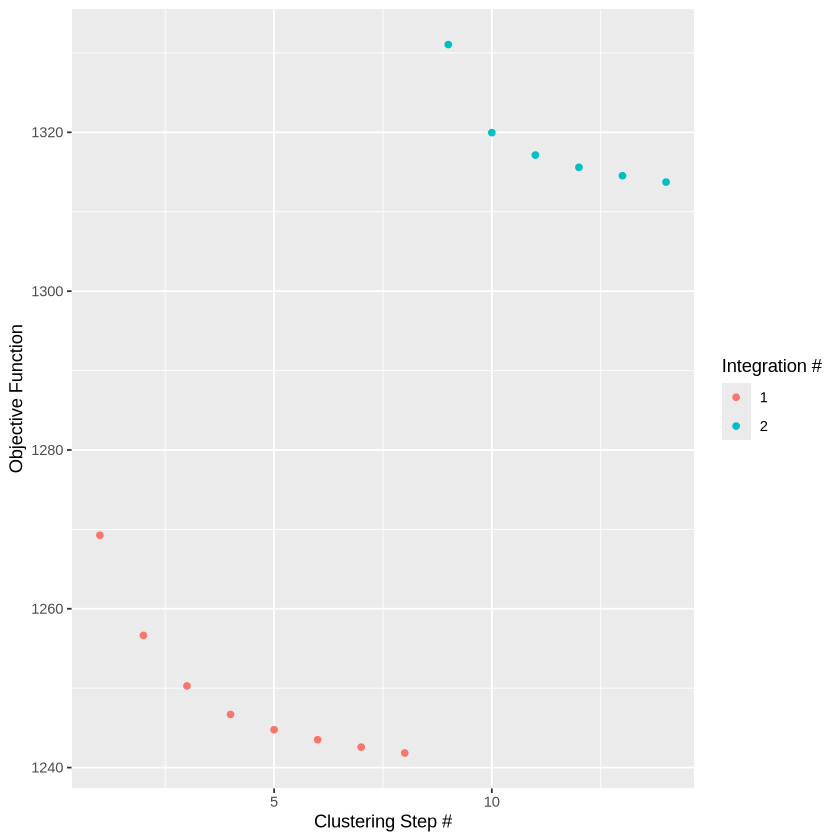

In [9]:
adata = RunHarmony(adata, "key_harmony",plot_convergence = TRUE)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


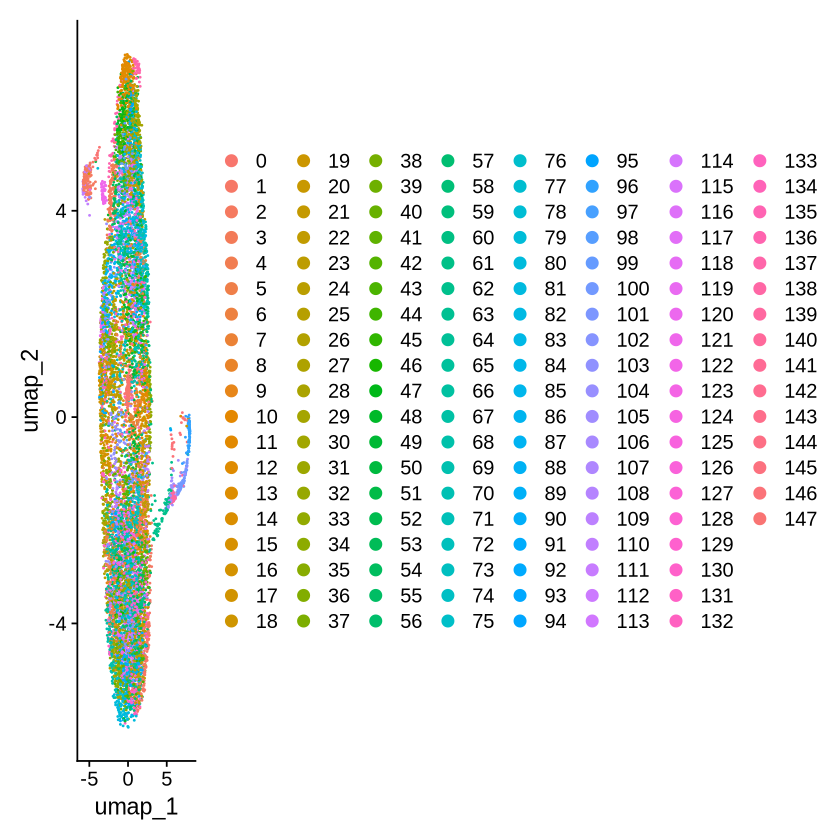

In [10]:
dims = 1:15
resolution = 0.1

adata <- RunUMAP(adata,reduction = "harmony", dims = dims,verbose = verbose)
adata <- FindNeighbors(adata, dims = dims,reduction = "harmony",verbose = verbose)
adata <- FindClusters(adata, resolution = dims,verbose = verbose,method='igraph')
DimPlot(adata, reduction = "umap")

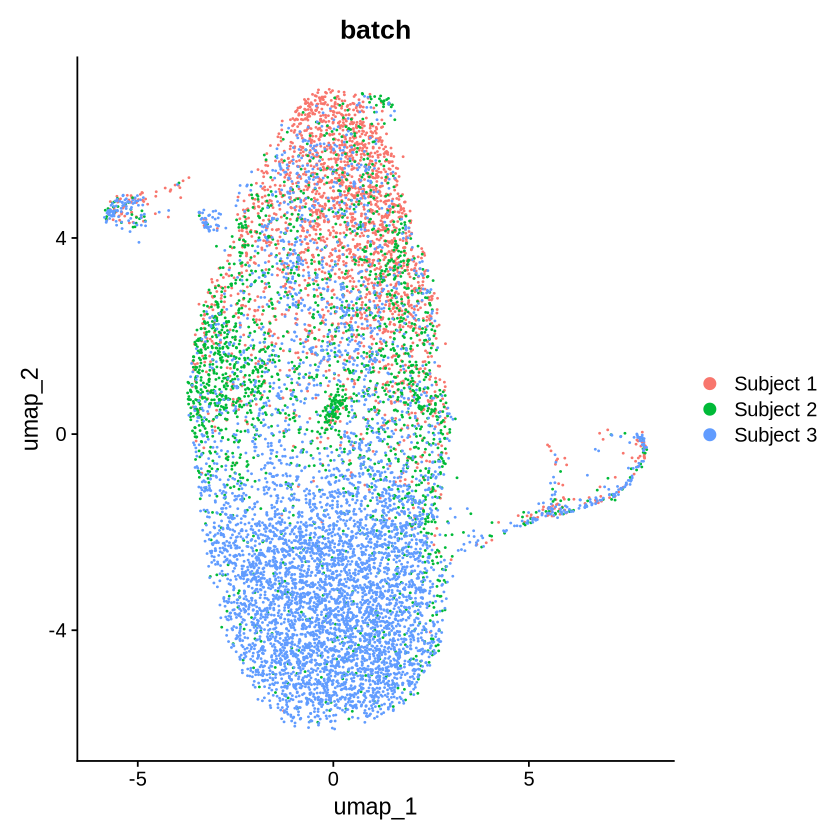

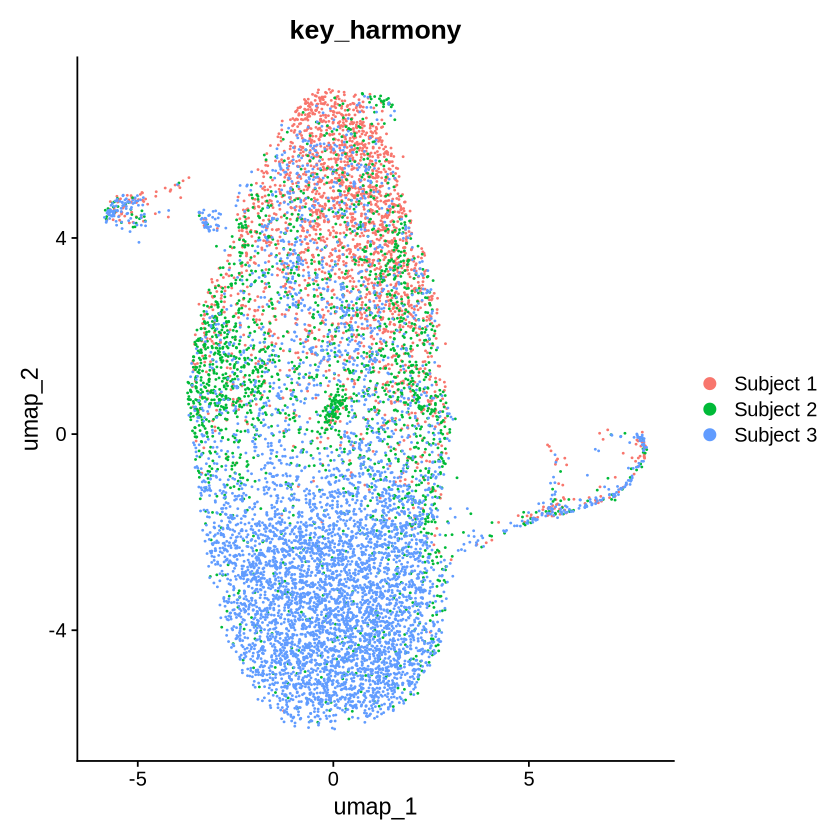

In [13]:
adata@meta.data = adata@meta.data %>% select(-matches('RNA_snn_res.+'))


# DimPlot(adata, reduction = "umap",group.by = 'Treatment')
DimPlot(adata, reduction = "umap",group.by = 'batch')
DimPlot(adata, reduction = "umap",group.by = "key_harmony")

In [14]:

df_cell_type = read_csv("bal_cell_type.txt")
df_cell_type %>% head()

Rows: 8 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): cell_type, sub_cell_type_1
dbl (1): seurat_clusters_article

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


cell_type,sub_cell_type_1,seurat_clusters_article
<chr>,<chr>,<dbl>
macrophage,AM_1,0
macrophage,AM_2,1
macrophage,AI,2
macrophage,AM_4,3
macrophage,AM_IM1,4
macrophage,IM_1,5


In [15]:
adata@meta.data = adata@meta.data %>% select(cell_id,batch,seurat_clusters_article)  %>% 
left_join(df_cell_type,by = 'seurat_clusters_article')
adata@meta.data %>% head(2)
adata@meta.data$cell_id %>% duplicated %>% all
rownames(adata@meta.data) = adata@meta.data$cell_id
adata@meta.data %>% group_by(seurat_clusters_article,sub_cell_type_1) %>% count

,cell_id,batch,seurat_clusters_article,cell_type,sub_cell_type_1
,<chr>,<chr>,<dbl>,<chr>,<chr>
1,AAACCCAAGTGCACCC_1,Subject 1,7,macrophage,AM_2_exclusive
2,AAACCCAGTGAGCTCC_1,Subject 1,0,macrophage,AM_1


[1] FALSE

seurat_clusters_article,sub_cell_type_1,n
<dbl>,<chr>,<int>
0,AM_1,5154
1,AM_2,3157
2,AI,1410
3,AM_4,281
4,AM_IM1,162
5,IM_1,108
6,AM_MT,49
7,AM_2_exclusive,36


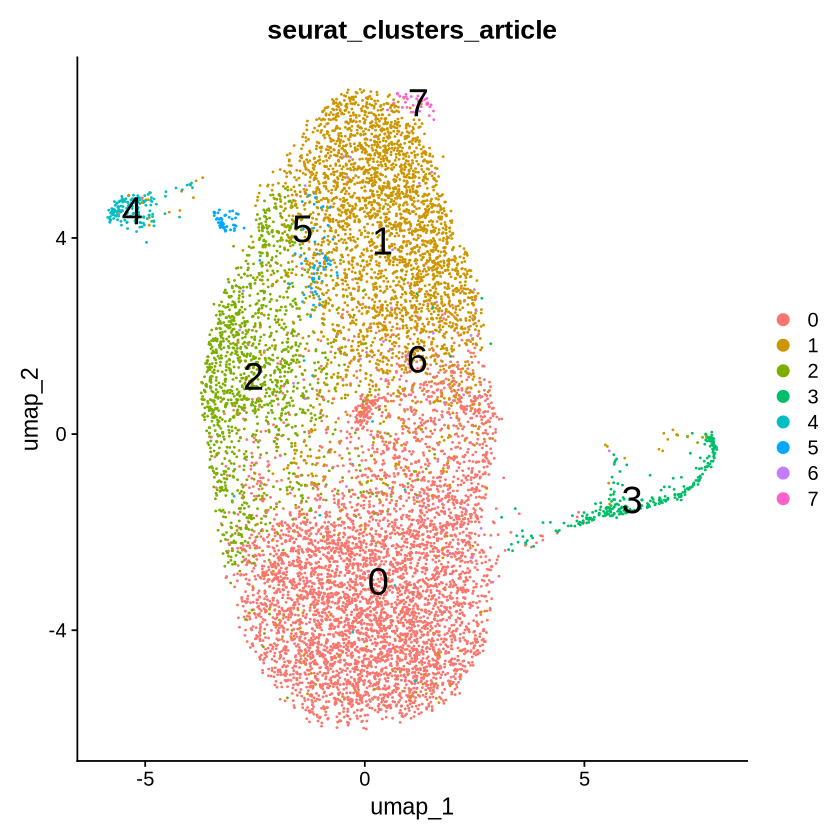

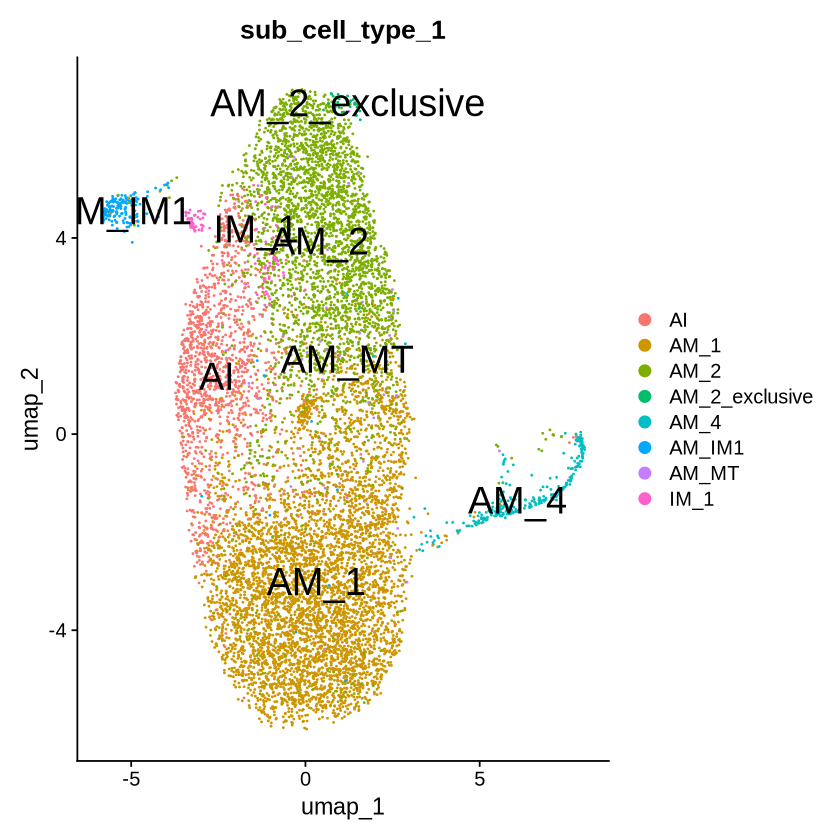

In [16]:

p = DimPlot(adata, reduction = "umap",group.by = 'seurat_clusters_article',
        label = T,label.size = 8)
p
ggsave('bal_umap_seurat_clusters_article.png',p,width = 150,height = 150,units = 'mm')

p = DimPlot(adata, reduction = "umap",group.by = 'sub_cell_type_1',
        label = T,label.size = 8)
p
ggsave('bal_umap_sub_cell_type_1.png',p,width = 150,height = 150,units = 'mm')

In [17]:
df_umap = adata@reductions$umap@cell.embeddings %>% as.data.frame %>% mutate(
 cell_id = rownames(adata@reductions$umap@cell.embeddings)
)
df_umap %>% head(2)
adata@meta.data %>% left_join(df_umap , by = 'cell_id') %>% write_csv("bal_ann.csv")

,umap_1,umap_2,cell_id
,<dbl>,<dbl>,<chr>
AAACCCAAGTGCACCC_1,1.432929,6.731284,AAACCCAAGTGCACCC_1
AAACCCAGTGAGCTCC_1,2.396438,-2.110921,AAACCCAGTGAGCTCC_1


In [18]:
for (gourp in 0:7) {
  cat(gourp, "\n")
  p_out <- file.path("markers", sprintf("bal_%d.csv", gourp))
  if (!file.exists(p_out)) {
    markers <- FindMarkers(adata, group.by = "seurat_clusters_article", ident.1 = gourp)
    markers %>% head()
    markers %>% dim()
    markers %>% mutate(
      gourp  = gourp,
      gene_name = rownames(markers), .before = 1
    ) %>% write_csv(p_out)
    cat(sprintf('[out] %s\n',p_out))
  }
}

0 
1 
2 
3 
4 
5 
6 
7 


In [19]:
cat('\nfinish\n')


finish
